Board Game Analysis for Adam Bartoszek
more explanation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

ab_collection_path = "./Collections/AB_Collection.csv"
jj_collection_path = "./Collections//JJ_Collection.csv"
bgg_collection_path = "./Collections//bgg_dataset.csv"
age_mapping_path = "./Collections//AgeRangeMapping.xlsx"
#mechanics_path = "./Database_Tables_BGG/mechanics.csv"
subcat_path = "./Database_Tables_BGG/subcategories.csv"
themes_path = "./Database_Tables_BGG/themes.csv"

jj_df = pd.read_csv(jj_collection_path, sep=',')
ab_df = pd.read_csv(ab_collection_path, sep=',')
bgg_df = pd.read_csv(bgg_collection_path, sep=';')
age_df = pd.read_excel(age_mapping_path, engine='openpyxl')
#mech_df = pd.read_csv(mechanics_path, sep=',')
sub_df = pd.read_csv(subcat_path, sep=',')
theme_df = pd.read_csv(themes_path, sep=',')

def filter_dataframe(df):
    # Filter out rows where 'itemtype' is not equal to 'expansion'
    filtered_df = df[df['itemtype'] != 'expansion']
    return filtered_df

def apply_suffix(df, suffix):
    # add suffix to all columns in DF to support easier separation and analysis
    return df.add_suffix(suffix)

def choose_age(row):
    # Check the values in my preferred order
    for col in ['bggrecagerange_ab', 'bggrecagerange_jj', 'Min Age']:
        if pd.notnull(row[col]):
            return row[col]
    return None  # Return None if all are NaN/NULL

jj_df_filtered = filter_dataframe(jj_df)
ab_df_filtered = filter_dataframe(ab_df)

jj_df_suffixed = apply_suffix(jj_df_filtered, '_jj')
ab_df_suffixed = apply_suffix(ab_df_filtered, '_ab')

ab_jj_outer = pd.merge(jj_df_suffixed, ab_df_suffixed, left_on='objectid_jj', right_on='objectid_ab', how='outer')
ab_jj_outer['objectid_comb'] = ab_jj_outer['objectid_ab'].combine_first(ab_jj_outer['objectid_jj'])
ab_jj_outer['bggrecagerange_comb'] = ab_jj_outer['bggrecagerange_ab'].combine_first(ab_jj_outer['bggrecagerange_jj'])
result = pd.merge(bgg_df, ab_jj_outer, left_on='ID', right_on='objectid_comb', how='left')
result['age_comb'] = result.apply(choose_age, axis=1)
result = pd.merge(result, age_df, left_on='age_comb', right_on='bggrecagerange', how='left')


#print(jj_df_suffixed.columns)
#print(ab_df_suffixed.columns)
#print(ab_jj_outer.columns)
print(list(result.columns))
row_count = result.count().max()
print(f"Number of rows: {row_count}")

['ID', 'Name', 'Year Published', 'Min Players', 'Max Players', 'Play Time', 'Min Age', 'Users Rated', 'Rating Average', 'BGG Rank', 'Complexity Average', 'Owned Users', 'Mechanics', 'Domains', 'objectname_jj', 'objectid_jj', 'rating_jj', 'numplays_jj', 'weight_jj', 'own_jj', 'fortrade_jj', 'want_jj', 'wanttobuy_jj', 'wanttoplay_jj', 'prevowned_jj', 'preordered_jj', 'wishlist_jj', 'wishlistpriority_jj', 'wishlistcomment_jj', 'comment_jj', 'conditiontext_jj', 'haspartslist_jj', 'wantpartslist_jj', 'collid_jj', 'baverage_jj', 'average_jj', 'avgweight_jj', 'rank_jj', 'numowned_jj', 'objecttype_jj', 'originalname_jj', 'minplayers_jj', 'maxplayers_jj', 'playingtime_jj', 'maxplaytime_jj', 'minplaytime_jj', 'yearpublished_jj', 'bggrecplayers_jj', 'bggbestplayers_jj', 'bggrecagerange_jj', 'bgglanguagedependence_jj', 'publisherid_jj', 'imageid_jj', 'year_jj', 'language_jj', 'other_jj', 'itemtype_jj', 'barcode_jj', 'version_publishers_jj', 'version_languages_jj', 'version_yearpublished_jj', 'vers

20327
1757
298
Out of the total 20327 games listed on Board Games Geek, Adam has 1757 or 8.64% and Judd has 298 or 1.47%


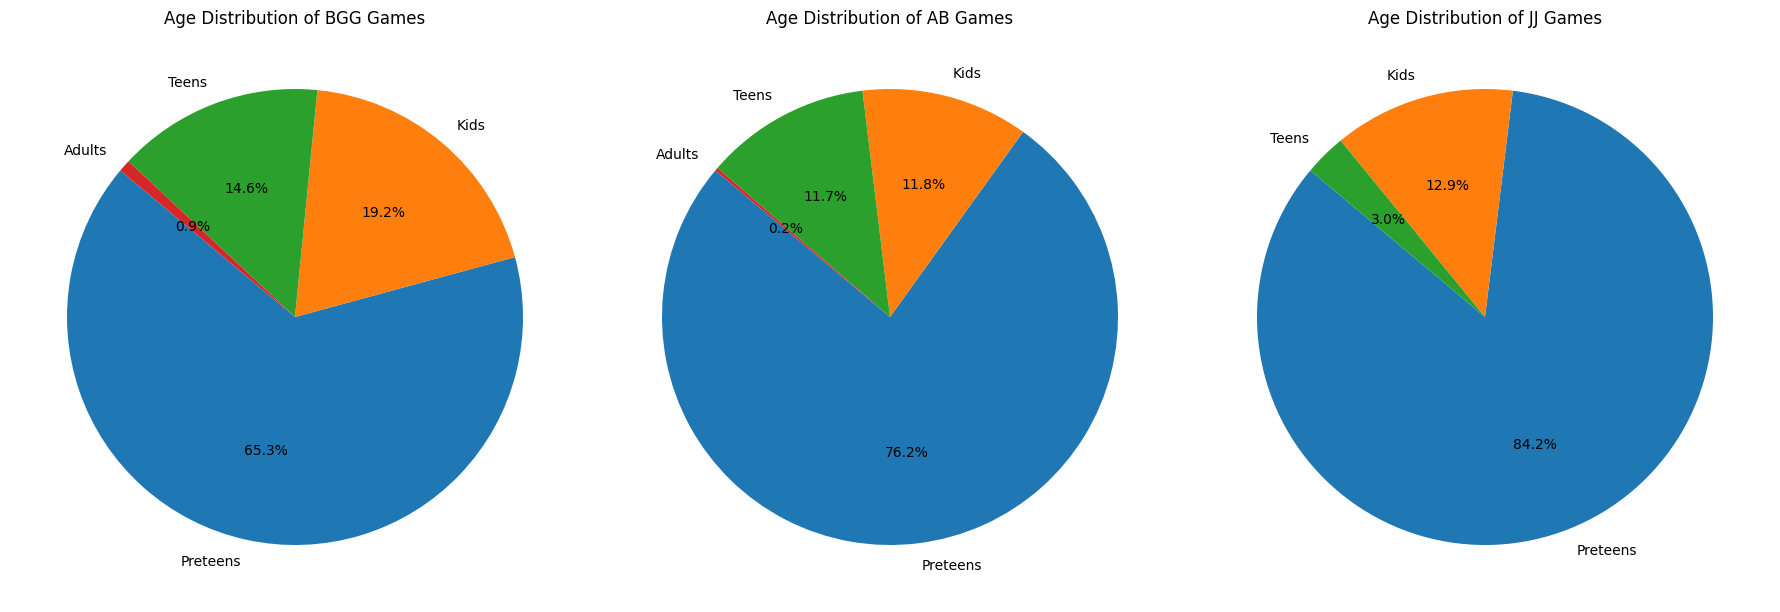

In [9]:
#Analysis
# Step 1: Count distinct values in 'ID' column
distinct_id_count = result['ID'].nunique()

# Step 2: Count distinct, non-NaN values in 'objectid_ab' column
dist_objectid_ab = result[result['itemtype_ab'] != 'expansion']['objectid_ab'].dropna().loc[result['objectid_ab'] != ''].nunique()
dist_objectid_jj = result[result['itemtype_jj'] != 'expansion']['objectid_jj'].dropna().loc[result['objectid_jj'] != ''].nunique()
print(distinct_id_count)
print(dist_objectid_ab)
print(dist_objectid_jj)
# Step 3: Calculate the percentage
ab_totalperc = round((dist_objectid_ab / distinct_id_count) * 100, 2)
jj_totalperc = round((dist_objectid_jj / distinct_id_count) * 100, 2)

bgg_age_counts = result['AggregateMapping'].value_counts()
ab_age_counts = result[result['objectid_ab'].notna()]['AggregateMapping'].value_counts()
jj_age_counts = result[result['objectid_jj'].notna()]['AggregateMapping'].value_counts()

# Print the result
print(f"Out of the total {distinct_id_count} games listed on Board Games Geek, Adam has {dist_objectid_ab} or {ab_totalperc}% and Judd has {dist_objectid_jj} or {jj_totalperc}%") 
#print(list(ab_age_counts))
#print(list(jj_age_counts))

# Output the result dataframe to an Excel file
#result.to_excel('result.xlsx', index=False)
#ab_jj_outer.to_excel('ab_jj_outer.xlsx', index=False)

# Create a figure with 1 row and 3 columns (for 3 pie charts)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns, adjust size as needed

# Pie chart for BGG
axes[0].pie(bgg_age_counts, labels=bgg_age_counts.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Age Distribution of BGG Games')

# Pie chart for AB
axes[1].pie(ab_age_counts, labels=ab_age_counts.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Age Distribution of AB Games')

# Pie chart for JJ
axes[2].pie(jj_age_counts, labels=jj_age_counts.index, autopct='%1.1f%%', startangle=140)
axes[2].set_title('Age Distribution of JJ Games')

# Display the pie charts
plt.tight_layout()  # Automatically adjusts the layout to prevent overlap
plt.show()
